https://github.com/nitarshan/variational-autoencoder/blob/master/Variational%20Autoencoder%20Tutorial.ipynb
https://github.com/3ammor/Variational-Autoencoder-pytorch/blob/master/graph/ce_model.py

#

In [0]:
!ls
!rm -rf nuclei-library-master

data  datalab  nuclei-library-master  processed  raw


In [0]:
!pip install torch torchvision tqdm scipy

In [0]:
!wget https://github.com/aiywatch/nuclei-library/archive/master.zip
!unzip master.zip
!rm -rf master.zip

In [0]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import autograd
from torchvision import transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from tqdm import tqdm
from torchvision.utils import make_grid as make_image_grid
import PIL
# from skimage.io import imread
from scipy.misc import imread
from scipy.stats import norm


# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
class ShapeDataset(Dataset):
  
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.shape_files = next(os.walk(root_dir))[2]

  def __len__(self):
    return len(self.shape_files)

  def __getitem__(self, idx):
    img_name = os.path.join(self.root_dir, self.shape_files[idx])

    image = imread(img_name)
    image = image.reshape(64,64,-1)

    if self.transform:
      image = self.transform(image)


    return image

In [0]:
# Data loaders# Data  
# trainloader = DataLoader(
#     MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()),
#     batch_size=128,shuffle=True)
# testloader = DataLoader(
#     MNIST(root='./data',train=False,download=True,transform=transforms.ToTensor()),
#     batch_size=128,shuffle=True)

t_trans = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.Resize((28,28),interpolation=PIL.Image.NEAREST),
    transforms.ToTensor(),
])

dataset = ShapeDataset('nuclei-library-master/shape', t_trans)#, transform=transforms.ToTensor())

trainloader = DataLoader(dataset, batch_size=40, shuffle=True)

In [0]:
class CDVAE(nn.Module):
  
    IMAGE_SIZE_ONE_DIM = 64
    IMAGE_SIZE = IMAGE_SIZE_ONE_DIM*IMAGE_SIZE_ONE_DIM
    
    def __init__(self,latent_dim=15,hidden_dim=100):
        super(CDVAE,self).__init__()
#         self.fc_e1 = nn.Conv2d(1, 20, 5, stride=1, bias=True)
        
        
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)
        
        self.fc_e2 = nn.Linear(16*16*16, hidden_dim)
        
        self.fc_mean = nn.Linear(hidden_dim,latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim,latent_dim)
        
        self.fc_d1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_d2 = nn.Linear(hidden_dim, 16*16*16)
#         self.fc_d2 = nn.Linear(hidden_dim, self.IMAGE_SIZE)

        self.conv5 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1, bias=False)
      
    def encoder(self,x_in):
      
        conv1 = F.relu(self.bn1(self.conv1(x_in)))
        conv2 = F.relu(self.bn2(self.conv2(conv1)))
        conv3 = F.relu(self.bn3(self.conv3(conv2)))
        conv4 = F.relu(self.bn4(self.conv4(conv3)))#.view(-1, 8 * 8 * 16)
        
#         x = F.relu(self.fc_e1(x_in))
#         print(conv4.shape)
  
        x = conv4.view(-1, self.num_flat_features(conv4))

        x = F.relu(self.fc_e2(x))
    
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar
    
    def decoder(self,z):
        z = F.relu(self.fc_d1(z))
        z = F.relu(self.fc_d2(z))
        
#         print(z.shape)
        
        z = z.view(-1, 16, 16, 16)
        
        
        conv5 = F.relu(self.bn5(self.conv5(z)))
        conv6 = F.relu(self.bn6(self.conv6(conv5)))
        conv7 = F.relu(self.bn7(self.conv7(conv6)))
        x_out = self.conv8(conv7)
#         print(x_out.shape)
#         x_out = F.sigmoid(self.fc_d2(z))
        x_out = F.sigmoid(x_out)

        return x_out
#         return x_out.view(-1,1, self.IMAGE_SIZE_ONE_DIM, self.IMAGE_SIZE_ONE_DIM)
    
    def sample_normal(self, mean, logvar):
        # Using torch.normal(means,sds) returns a stochastic tensor which we cannot backpropogate through.
        # Instead we utilize the 'reparameterization trick'.
        # http://stats.stackexchange.com/a/205336
        # http://dpkingma.com/wordpress/wp-content/uploads/2015/12/talk_nips_workshop_2015.pdf
        sd = torch.exp(logvar*0.5)
        e = Variable(torch.randn(sd.size())).cuda() # Sample from standard normal
        z = e.mul(sd).add_(mean)
        return z
    
    def forward(self,x_in):
#         print(x_in.shape)
        z_mean, z_logvar = self.encoder(x_in)
        z = self.sample_normal(z_mean,z_logvar)
        
        x_out = self.decoder(z)
        return x_out, z_mean, z_logvar
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
      
      
# Loss function# Loss  
BETA = 3

def criterion(x_out,x_in,z_mu,z_logvar):
    
    bce_loss = F.binary_cross_entropy(x_out,x_in,size_average=False)
    kld_loss = -0.5 * torch.sum(1 + z_logvar - (z_mu ** 2) - torch.exp(z_logvar))
    loss = (bce_loss + BETA * kld_loss) / x_out.size(0) # normalize by batch size
    return loss



In [0]:
# Training
def train(model,optimizer,dataloader,epochs=100):
  losses = []
  mse = []

  total_se = 0
  total_size = 0
  
  for epoch in tqdm(range(epochs)):
    for images in dataloader:
      images = images.cuda()
      optimizer.zero_grad()
      x_out, z_mu, z_logvar = model(images)
      loss = criterion(x_out, images, z_mu, z_logvar)
      loss.backward()
      optimizer.step()
      losses.append(loss.data[0])

      squared_error = F.mse_loss(x_out, images, size_average=False)
      total_se += squared_error.data.tolist()
      total_size += images.shape[0]
      
    mse.append(total_se / total_size)
      
  return losses, mse

# Visualize VAE input and reconstruction
def visualize_mnist_vae(model,dataloader,num=16):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
        
    images = iter(dataloader).next()
    images = images[0:num,:,:].cuda()
    x_in = Variable(images)
    x_out,_,_ = model(x_in)
    x_out = x_out.data
    imshow(make_image_grid(images.cpu()))
    imshow(make_image_grid(x_out.cpu()))

In [0]:
LATENT_SIZES = [10, 14, 18, 22, 26, 30]
EPOCHS = 200

train_logs = []
mse_logs = []

for latent_size in LATENT_SIZES:
  print("starting", latent_size)
  
  model = CDVAE(latent_dim=latent_size)
  model.cuda()

  optimizer = torch.optim.Adam(model.parameters())

  train_losses, mse = train(model, optimizer, trainloader, EPOCHS)
  
  print('latent size', latent_size, 'mse', mse[-1])
  
  train_logs.append(train_losses)
  mse_logs.append(mse)

starting 10


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()
  0%|          | 0/200 [00:00<?, ?it/s]

latent size 10 mse 35.75863883858372
starting 14


  0%|          | 0/200 [00:00<?, ?it/s]

latent size 14 mse 36.166169875527125
starting 18


  0%|          | 0/200 [00:00<?, ?it/s]

latent size 18 mse 37.03946678968309
starting 22


  0%|          | 0/200 [00:00<?, ?it/s]

latent size 22 mse 36.65168231644218
starting 26


  0%|          | 0/200 [00:00<?, ?it/s]

latent size 26 mse 38.68087078657141
starting 30


100%|██████████| 200/200 [31:42<00:00,  9.51s/it]

latent size 30 mse 60.691623699275475


In [0]:
for i, size in enumerate(LATENT_SIZES):
  print(f'size: {size}, loss: {train_logs[i][-1].data.tolist()}, mse: {mse_logs[i][-1]}')

size: 10, loss: 142.88861083984375, mse: 35.75863883858372
size: 14, loss: 177.12167358398438, mse: 36.166169875527125
size: 18, loss: 180.11122131347656, mse: 37.03946678968309
size: 22, loss: 163.29212951660156, mse: 36.65168231644218
size: 26, loss: 153.4523162841797, mse: 38.68087078657141
size: 30, loss: 164.49867248535156, mse: 60.691623699275475


size: 10


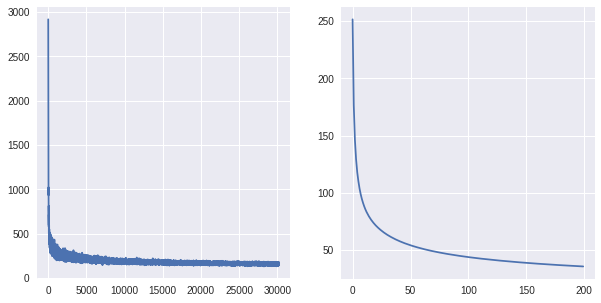

size: 14


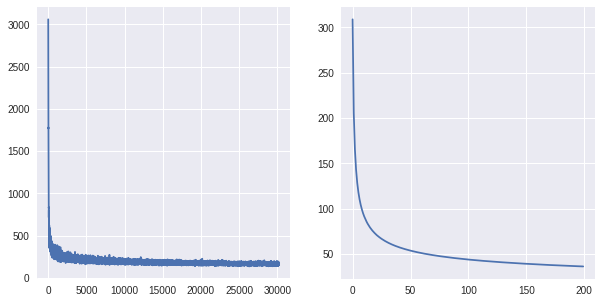

size: 18


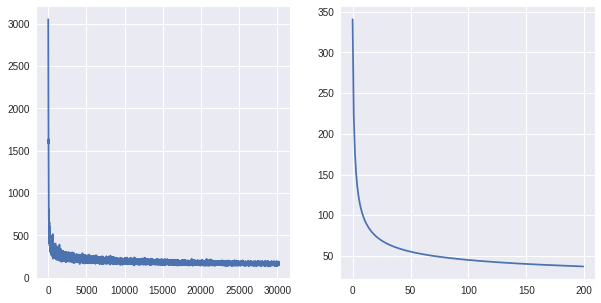

size: 22


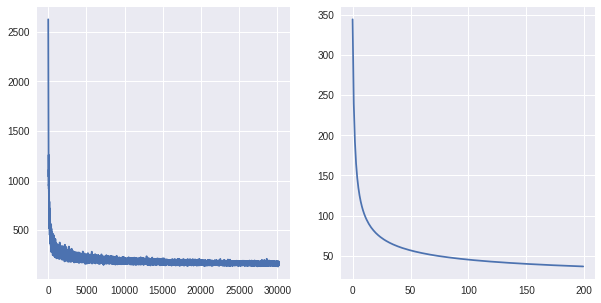

size: 26


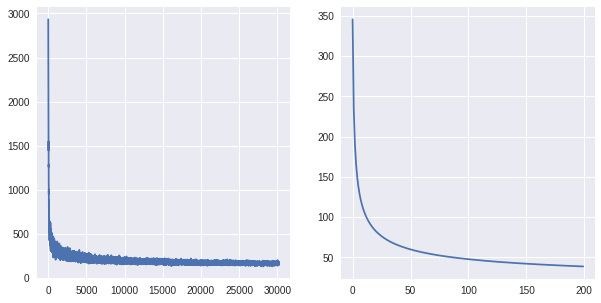

size: 30


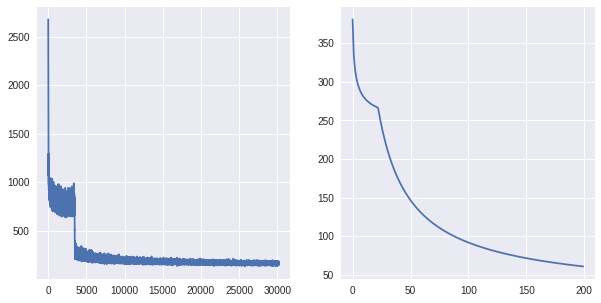

In [0]:
for i, size in enumerate(LATENT_SIZES):
  print(f'size: {size}')
  
  plt.figure(figsize=(10,5))
  
  plt.subplot(121)
  plt.plot(train_logs[i])
  plt.subplot(122)
  plt.plot(mse_logs[i])
  plt.show()

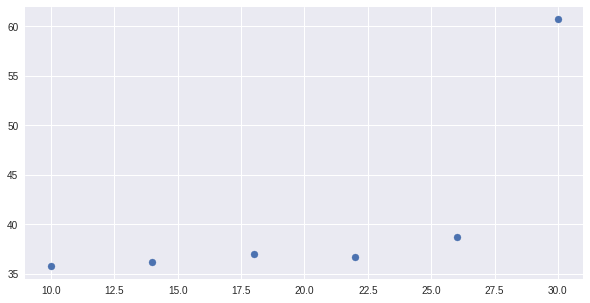

In [0]:
mse_logs = np.array(mse_logs)

plt.figure(figsize=(10,5))
plt.scatter(LATENT_SIZES, mse_logs[:, -1])
plt.show()

In [0]:
LATENT_SIZE = 10
EPOCHS = 300

model = CDVAE(latent_dim=LATENT_SIZE)
model.cuda()

optimizer = torch.optim.Adam(model.parameters())

train_losses, mse = train(model, optimizer, trainloader, EPOCHS)

  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()
100%|██████████| 300/300 [46:58<00:00,  9.39s/it]


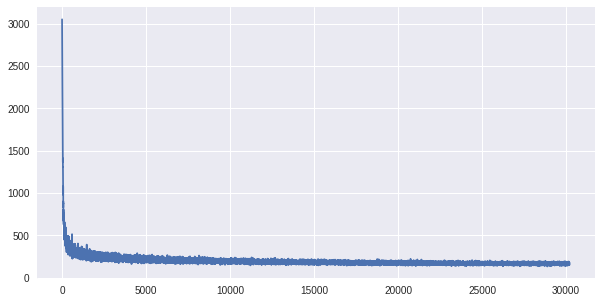

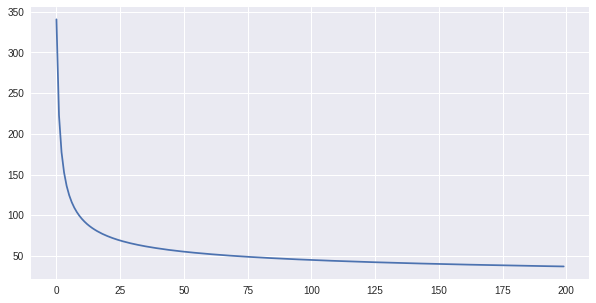

In [0]:
plt.figure(figsize=(10,5))
plt.plot(train_logs[2])
plt.show()
plt.figure(figsize=(10,5))
plt.plot(mse_logs[2])
plt.show()

## Finding ERROR

In [0]:
total_loss = 0
total_size = 0

for images in trainloader:
  
    images = images.cuda()
    x_out, z_mu, z_logvar = model(images)
    
    x_out[x_out >= 0.5] = 1
    x_out[x_out < 0.5] = 0
    
    images[images >= 0.5] = 1
    images[images < 0.5] = 0
    
    
    squared_error = F.mse_loss(x_out, images, size_average=False)
    size = images.shape[0]
    
#     print(squared_error.data.tolist(), size)
    total_loss += squared_error.data.tolist()
    total_size += size

print('average error in each mask', total_loss / total_size)
print('average error per pixel', (total_loss / total_size) / (64*64) )

avery error in each mask 32.73715611534637
every error per pixel 0.007992469754723236


## Qualitative results

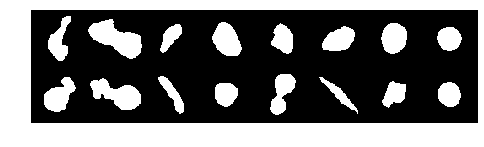

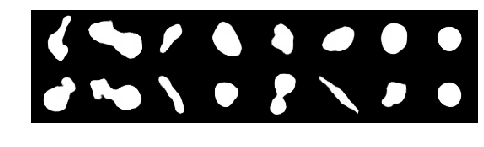

In [0]:


visualize_mnist_vae(model,trainloader)

In [0]:
LATENT_SIZE = 15
EPOCHS = 300

model = CDVAE(latent_dim=LATENT_SIZE)
model.cuda()

optimizer = torch.optim.Adam(model.parameters())

train_losses, mse = train(model, optimizer, trainloader, EPOCHS)

  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()
100%|██████████| 300/300 [47:00<00:00,  9.40s/it]


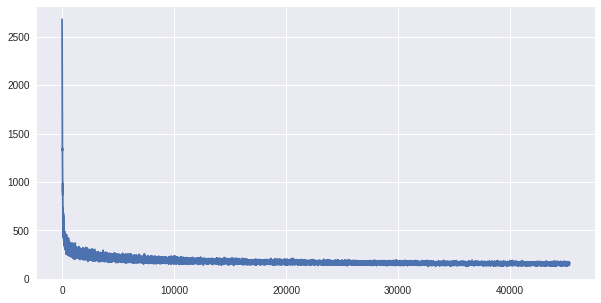

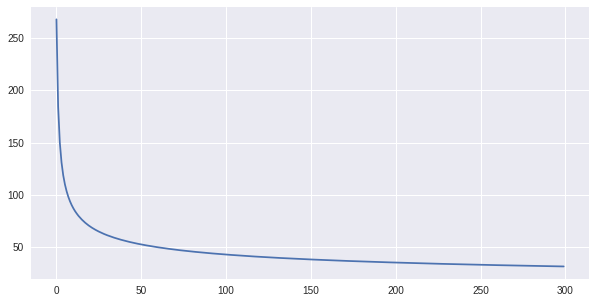

In [0]:
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(mse)
plt.show()

In [0]:
total_loss = 0
total_size = 0

for images in trainloader:
  
    images = images.cuda()
    x_out, z_mu, z_logvar = model(images)
    
    x_out[x_out >= 0.5] = 1
    x_out[x_out < 0.5] = 0
    
    images[images >= 0.5] = 1
    images[images < 0.5] = 0
    
    
    squared_error = F.mse_loss(x_out, images, size_average=False)
    size = images.shape[0]
    
#     print(squared_error.data.tolist(), size)
    total_loss += squared_error.data.tolist()
    total_size += size

print('average error in each mask', total_loss / total_size)
print('average error per pixel', (total_loss / total_size) / (64*64) )

average error in each mask 33.08352668213457
average error per pixel 0.00807703288138051


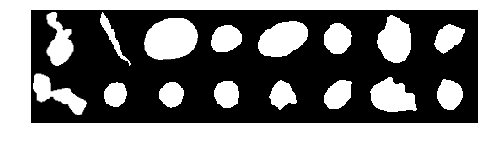

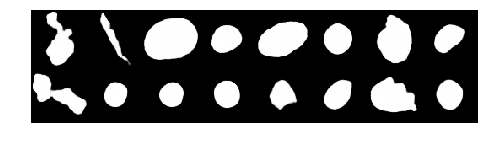

In [0]:
# Visualize VAE input and reconstruction
def visualize_mnist_vae(model,dataloader,num=16):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
        
    images = iter(dataloader).next()
    images = images[0:num,:,:].cuda()
    x_in = Variable(images)
    x_out,_,_ = model(x_in)
    x_out = x_out.data
    imshow(make_image_grid(images.cpu()))
    imshow(make_image_grid(x_out.cpu()))

visualize_mnist_vae(model,trainloader)

In [0]:
LATENT_SIZE = 8
EPOCHS = 300

model = CDVAE(latent_dim=LATENT_SIZE)
model.cuda()

optimizer = torch.optim.Adam(model.parameters())

train_losses, mse = train(model, optimizer, trainloader, EPOCHS)

In [0]:
total_loss = 0
total_size = 0

for images in trainloader:
  
    images = images.cuda()
    x_out, z_mu, z_logvar = model(images)
    
    x_out[x_out >= 0.5] = 1
    x_out[x_out < 0.5] = 0
    
    images[images >= 0.5] = 1
    images[images < 0.5] = 0
    
    
    squared_error = F.mse_loss(x_out, images, size_average=False)
    size = images.shape[0]
    
#     print(squared_error.data.tolist(), size)
    total_loss += squared_error.data.tolist()
    total_size += size

print('average error in each mask', total_loss / total_size)
print('average error per pixel', (total_loss / total_size) / (64*64) )

average error in each mask 34.6909181305933
average error per pixel 0.00846946243422688


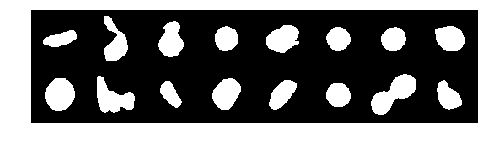

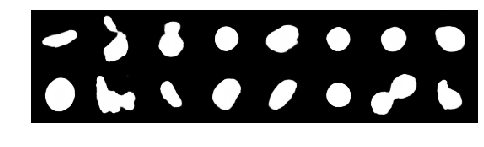

In [0]:
visualize_mnist_vae(model,trainloader)

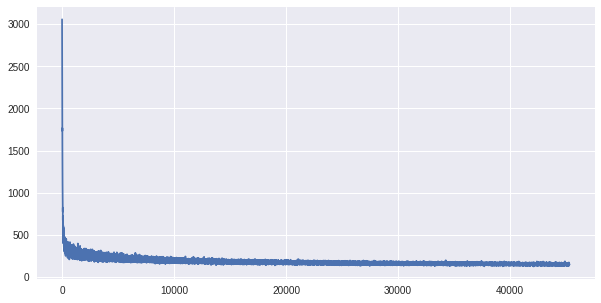

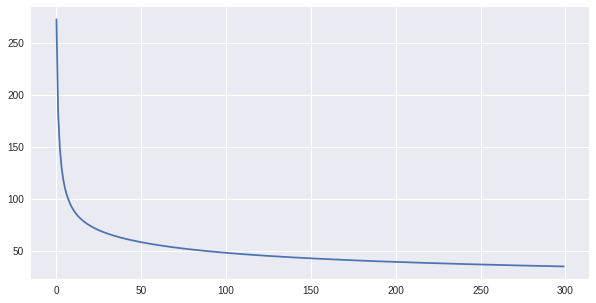

In [0]:
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.show()
plt.figure(figsize=(10,5))
plt.plot(mse)
plt.show()

In [0]:
num=20
range_space = np.linspace(-10,10,num)

range_space

array([-10.        ,  -8.94736842,  -7.89473684,  -6.84210526,
        -5.78947368,  -4.73684211,  -3.68421053,  -2.63157895,
        -1.57894737,  -0.52631579,   0.52631579,   1.57894737,
         2.63157895,   3.68421053,   4.73684211,   5.78947368,
         6.84210526,   7.89473684,   8.94736842,  10.        ])

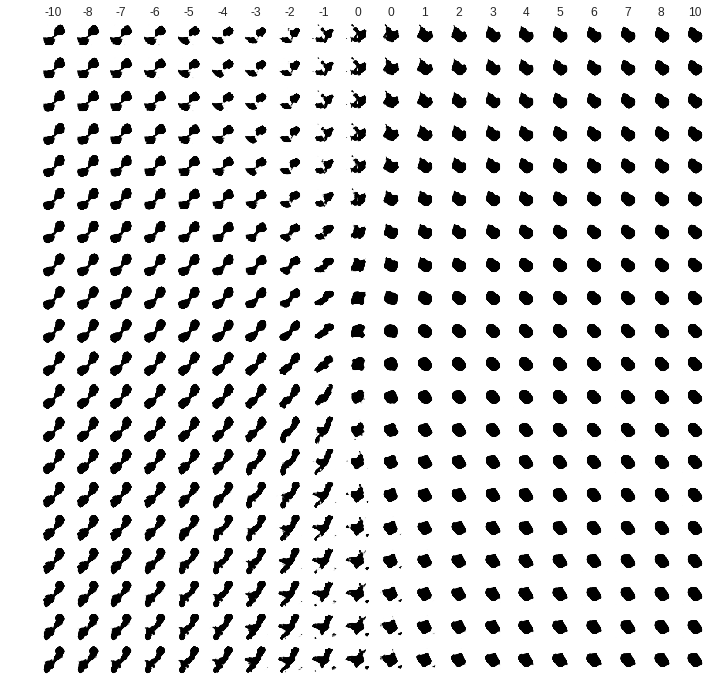

In [0]:
Z_DIM1 = 1
Z_DIM2 = 2

z = torch.zeros(LATENT_SIZE).cuda()

fig, ax = plt.subplots(20,20, figsize=(12,12))

for i, n in enumerate(range_space):
  z[Z_DIM1] = n
  
  for j, m in enumerate(range_space):
    z[Z_DIM2] = m
    out = model.decoder(z)
    out.shape
    ax[i, j].imshow(out.view(64,64).detach().cpu().numpy())
    ax[i, j].axis('off')
    if i==0:
      ax[i, j].set_title(int(m))
    if j==0:
      ax[i, j].set_ylabel(int(n), rotation=0, size='large')
      
plt.show()

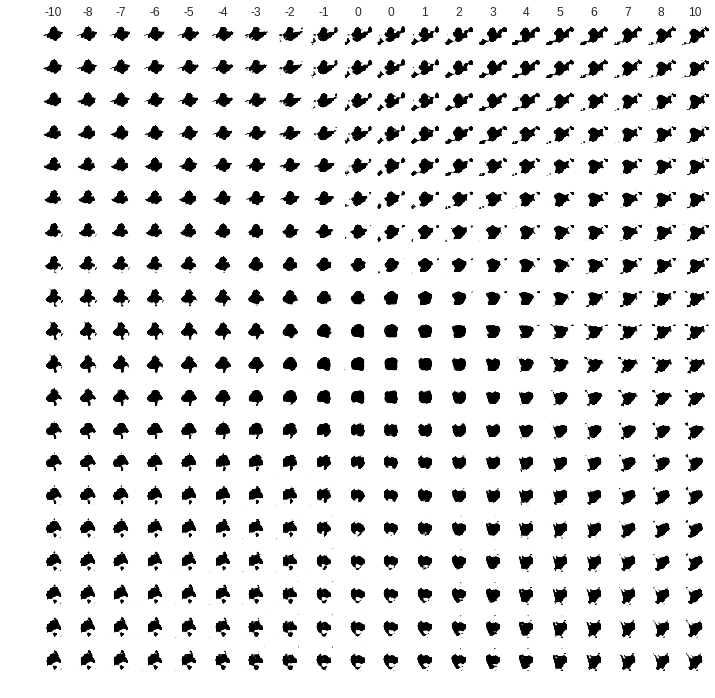

In [0]:
Z_DIM1 = 3
Z_DIM2 = 4

z = torch.zeros(LATENT_SIZE).cuda()

fig, ax = plt.subplots(20,20, figsize=(12,12))

for i, n in enumerate(range_space):
  z[Z_DIM1] = n
  
  for j, m in enumerate(range_space):
    z[Z_DIM2] = m
    out = model.decoder(z)
    out.shape
    ax[i, j].imshow(out.view(64,64).detach().cpu().numpy())
    ax[i, j].axis('off')
    if i==0:
      ax[i, j].set_title(int(m))
    if j==0:
      ax[i, j].set_ylabel(int(n), rotation=0, size='large')
      
plt.show()

#Save model

In [0]:
!ls 

datalab     dvae_model.pt   dvae_model.tar.gz
dvae_model  dvae_model.tar  nuclei-library-master


In [0]:
from google.colab import files
torch.save(model.state_dict(), './dvae_model')
files.download('dvae_model')

In [0]:
model2 = VAE()
model2.load_state_dict(torch.load('./dvae_model'))
model2.cuda()

VAE(
  (fc_e): Linear(in_features=4096, out_features=100, bias=True)
  (fc_mean): Linear(in_features=100, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=100, out_features=10, bias=True)
  (fc_d1): Linear(in_features=10, out_features=100, bias=True)
  (fc_d2): Linear(in_features=100, out_features=4096, bias=True)
)

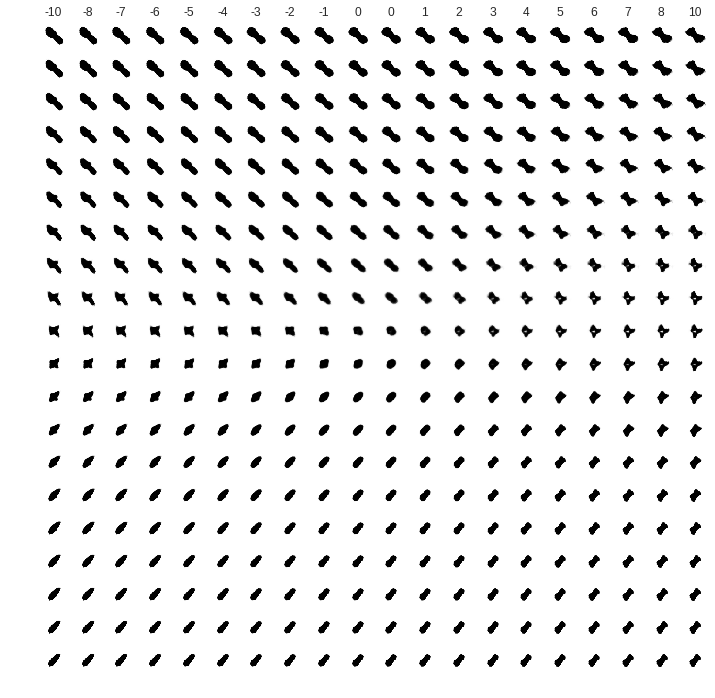

In [0]:
Z_DIM1 = 3
Z_DIM2 = 4

z = torch.zeros(10).cuda()

fig, ax = plt.subplots(20,20, figsize=(12,12))

for i, n in enumerate(range_space):
  z[Z_DIM1] = n
  
  for j, m in enumerate(range_space):
    z[Z_DIM2] = m
    out = model2.decoder(z)
    out.shape
    ax[i, j].imshow(out.view(64,64).detach().cpu().numpy())
    ax[i, j].axis('off')
    if i==0:
      ax[i, j].set_title(int(m))
    if j==0:
      ax[i, j].set_ylabel(int(n), rotation=0, size='large')
      
plt.show()